# Telecom

## Plan

Task description: The telecom operator "Niedinogorazryva.com" wants to learn how to predict the outflow of customers. If it turns out that the user plans to leave, he will be offered promotional codes and special conditions.

In [1]:
import pandas as pd

In [2]:
contracts = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Analysis

#### Contracts info

In [3]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


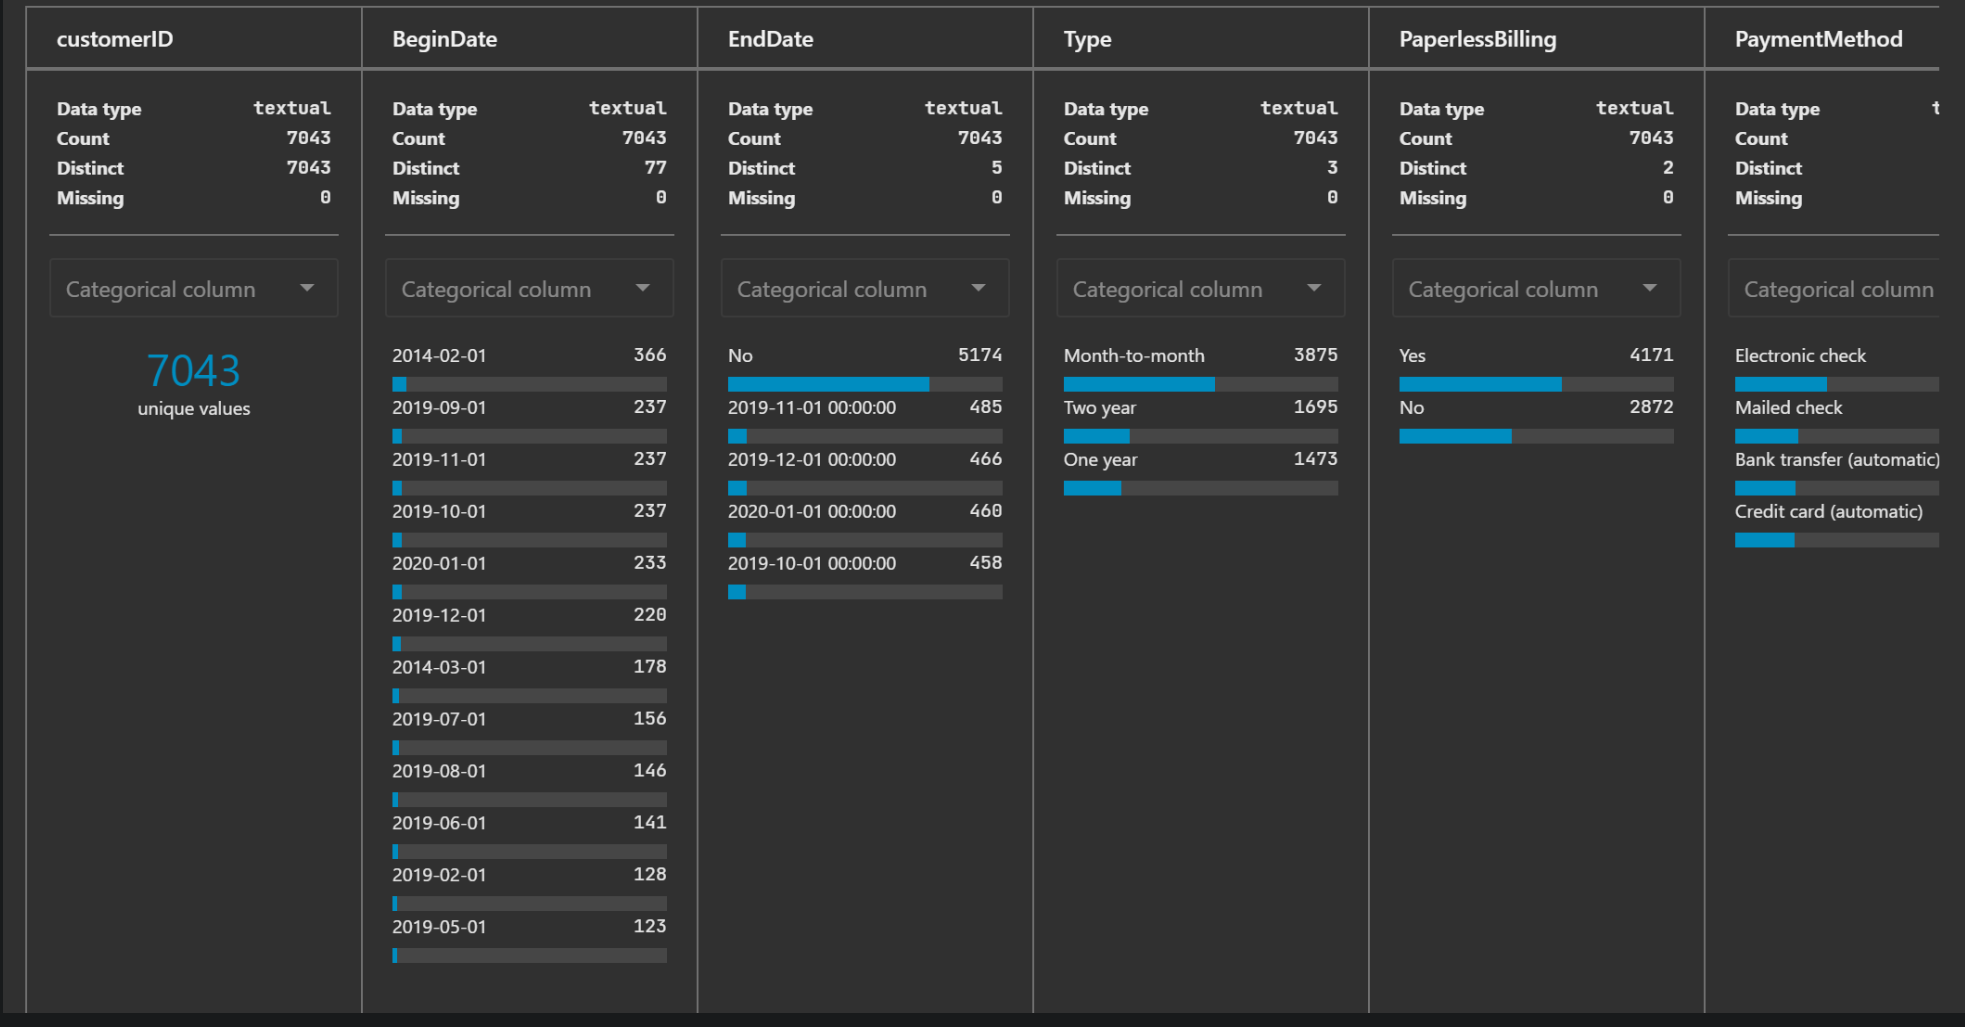

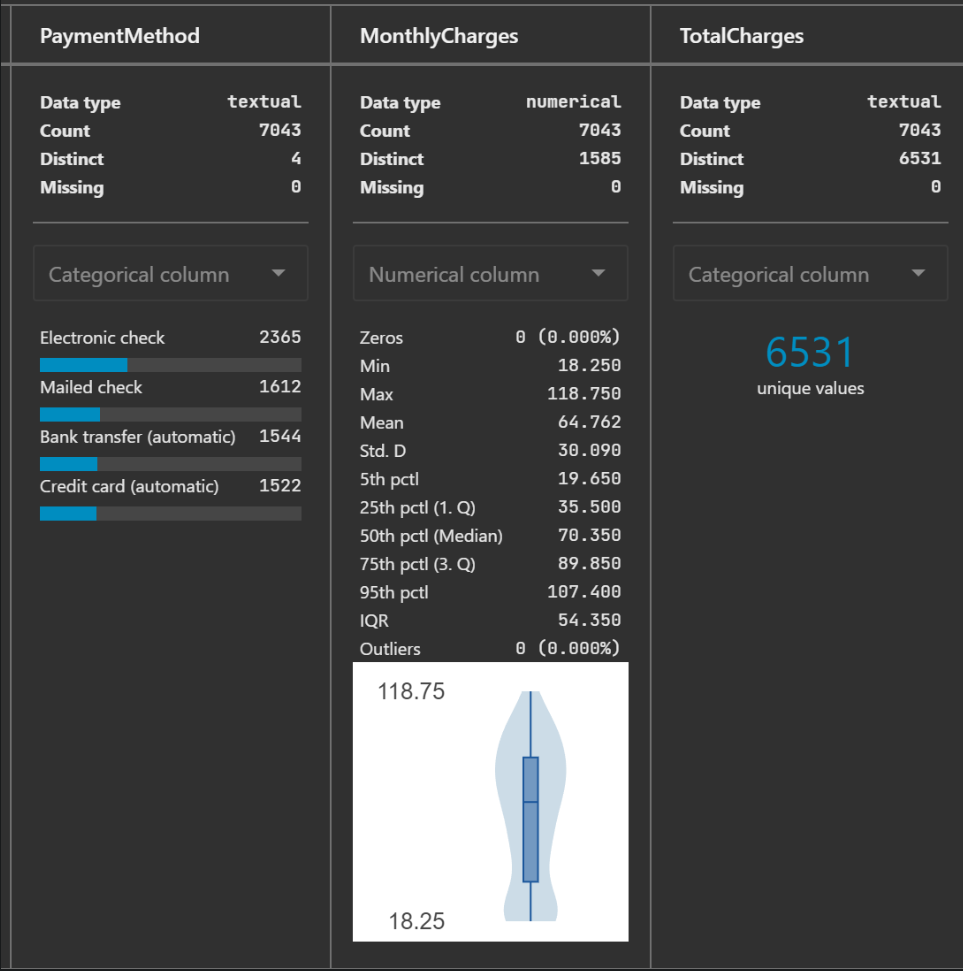

#### Personal data

In [5]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


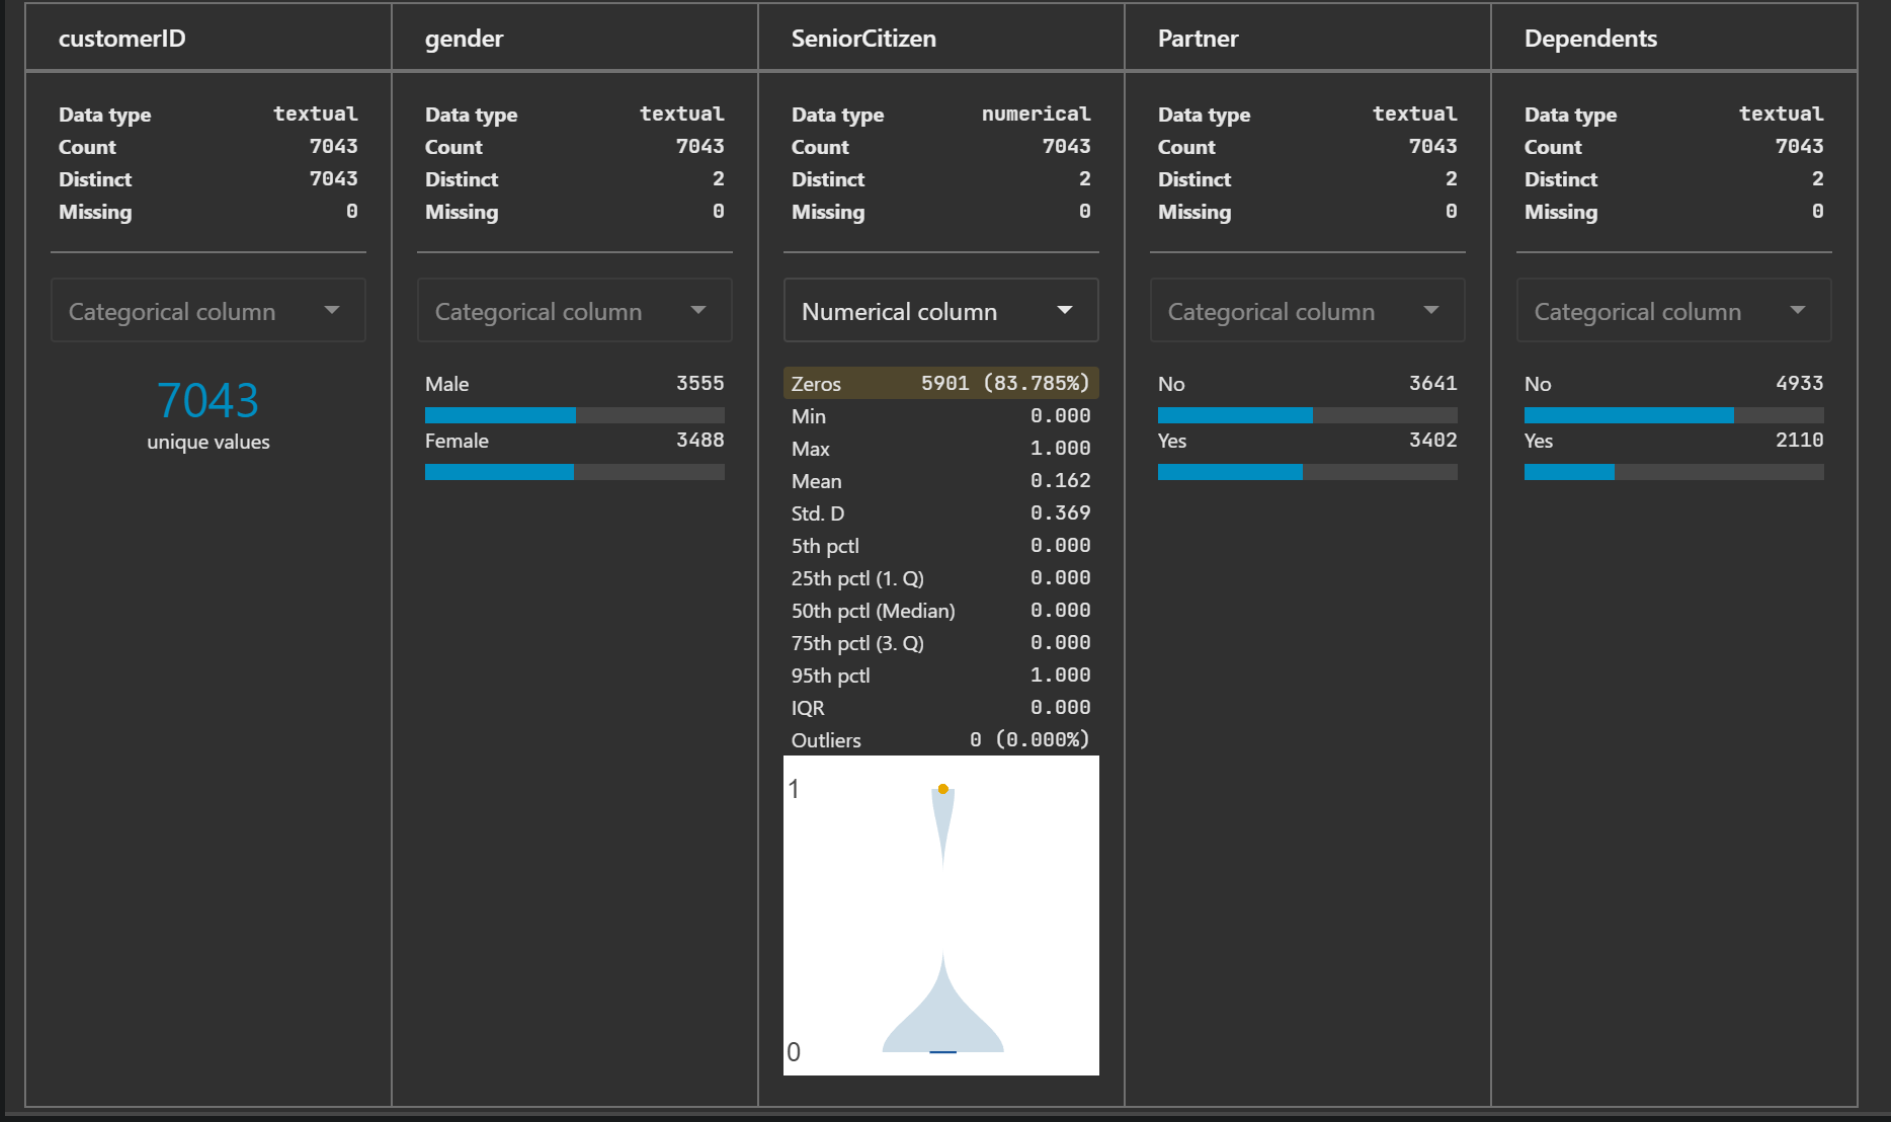

#### Internet services information

internet.info()

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


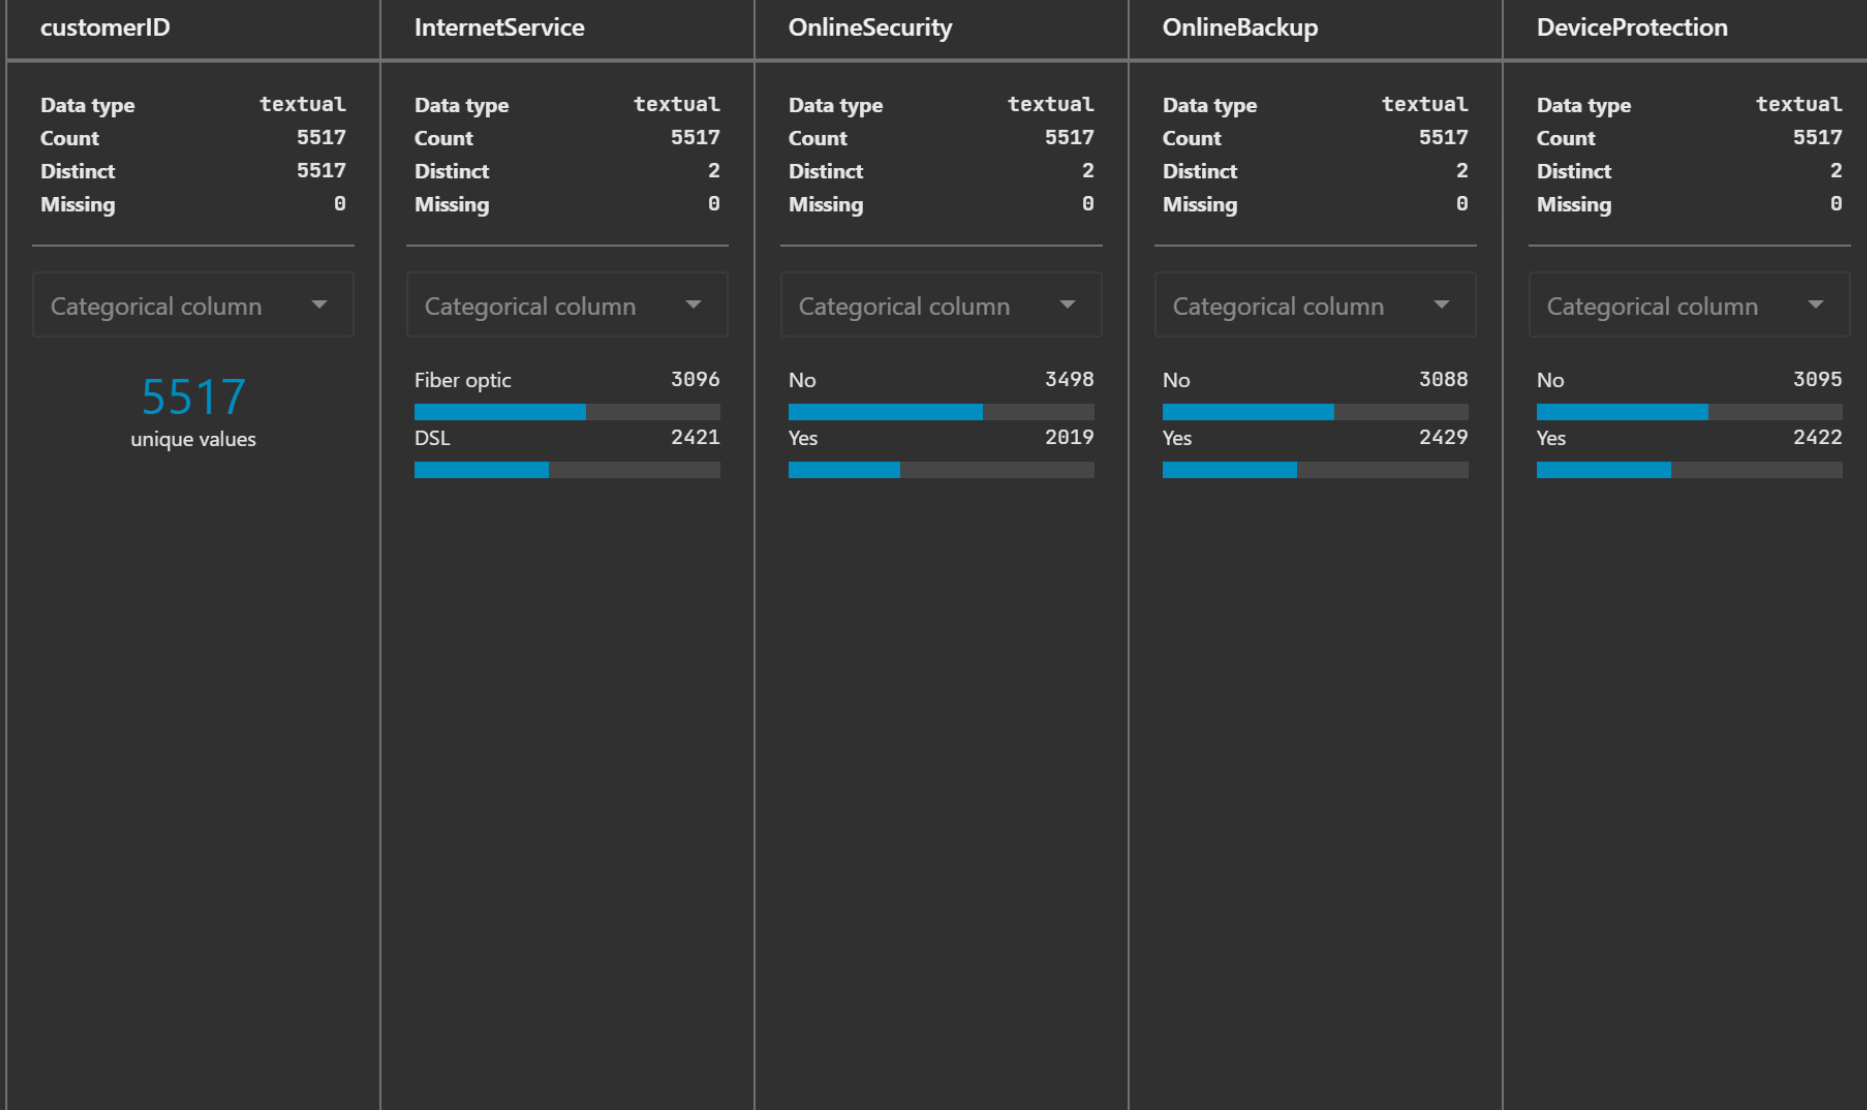

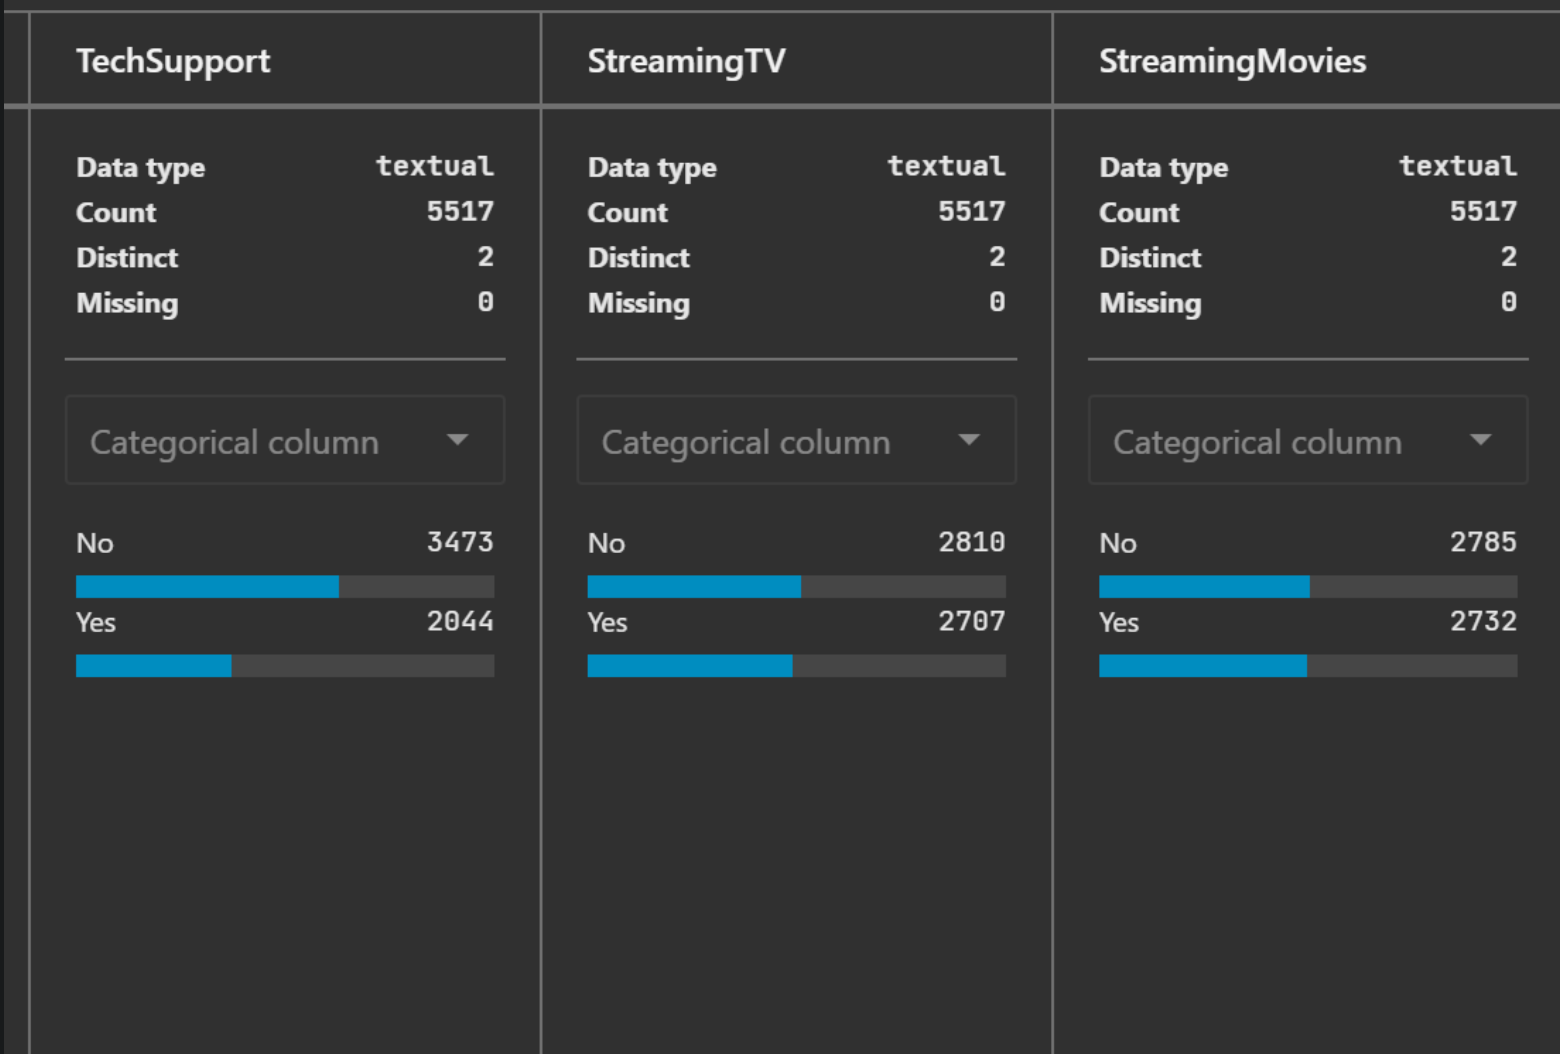

#### Telephony information

In [8]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


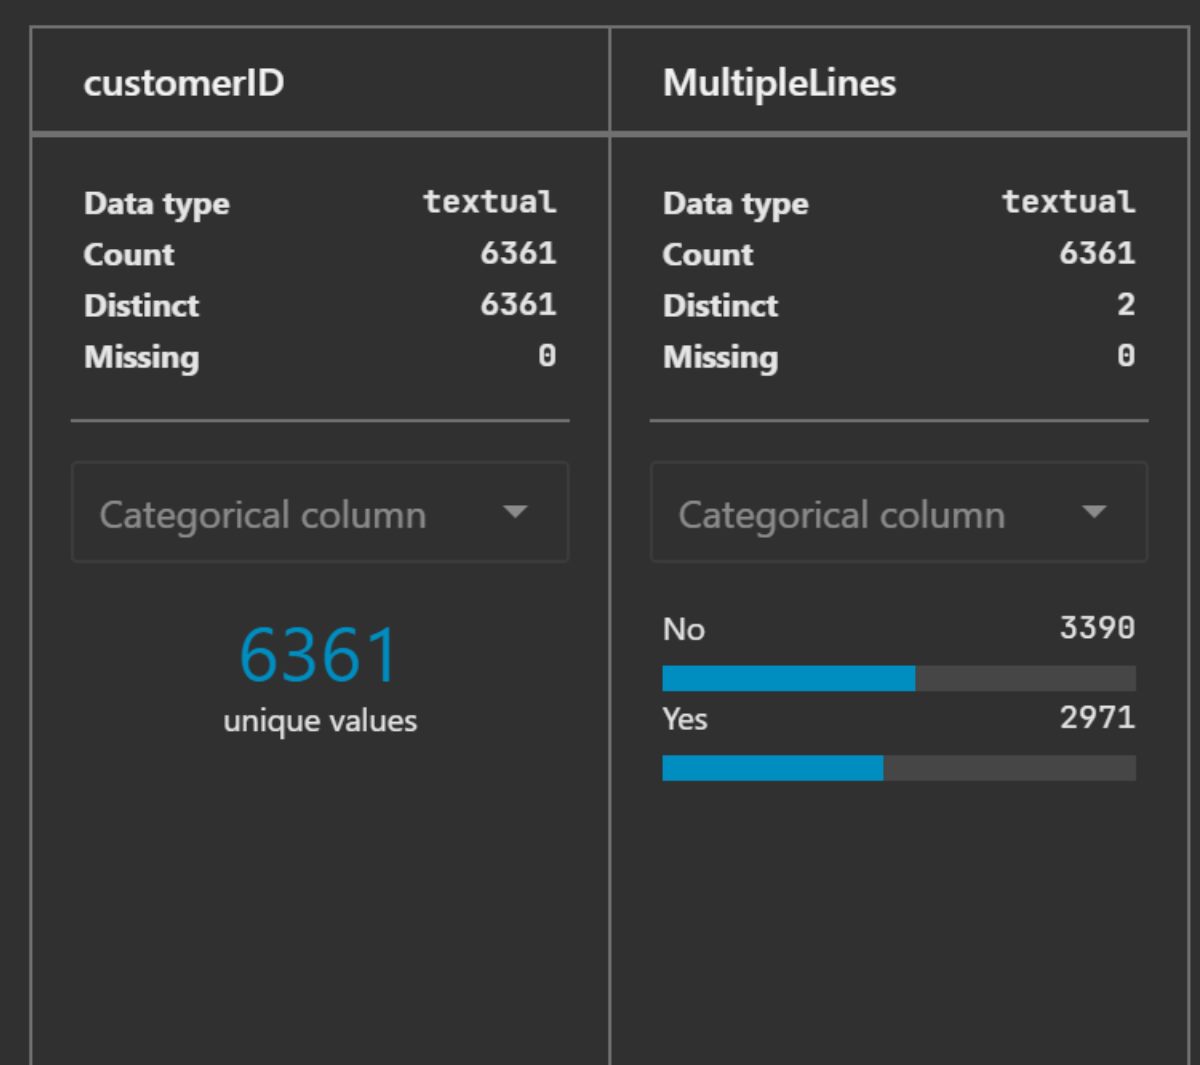

### Conclusion

In [10]:
contracts[contracts.EndDate != 'No'].shape[0] / contracts.shape[0] * 100

26.536987079369588

The data looks correct. There is no missing data. For customers, there is always data on contracts and personal data. And there may be missing / present data on telephony or Internet services.

### Plan

1) Exploratory analysis. Tidy up column names, types  
2) Based on the contracts.EndDate column, create a target sign, the client left if EndDate is not equal to 'No'. (26% of entries) On the base of the iss. analysis it is possible to generate additional signs.  
3) Prepare the data for training, split the data.  
4) Train several models, choose the best one.  
5) Test the best model on test data. Write a conclusion.  

### Target

Predict customer churn.

In [11]:
%%capture
pip install phik

## Solution

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool

import phik
from phik.report import plot_correlation_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
sns.set(rc={"figure.figsize": (10, 4)});

In [14]:
contracts = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [15]:
rnd_state = 160123

## Analysis

### Renaming columns

In [16]:
#rename columns
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')
#rename customerID
def rename_with_customer_id(df):
    df.rename(columns={'customerID': 'customerId'}, inplace=True)
    df.rename(camel_to_snake, inplace=True, axis=1)

In [17]:
rename_with_customer_id(contracts)
rename_with_customer_id(personal)
rename_with_customer_id(internet)
rename_with_customer_id(phone)

### Contracts info

In [18]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [19]:
contracts.replace(' ', 0, inplace=True)

In [20]:
contracts.total_charges = contracts.total_charges.astype('float64')
contracts.begin_date = pd.to_datetime(contracts.begin_date)

In [21]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [22]:
contracts.duplicated().sum()

0

In [23]:
min(contracts.begin_date)

Timestamp('2013-10-01 00:00:00')

In [24]:
max(contracts.begin_date)

Timestamp('2020-02-01 00:00:00')

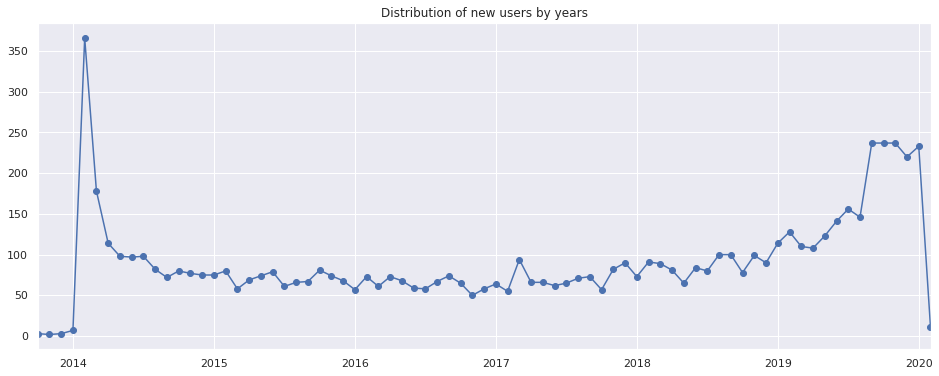

In [25]:
contracts.begin_date.value_counts().sort_index().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Distribution of new users by years")
plt.show()

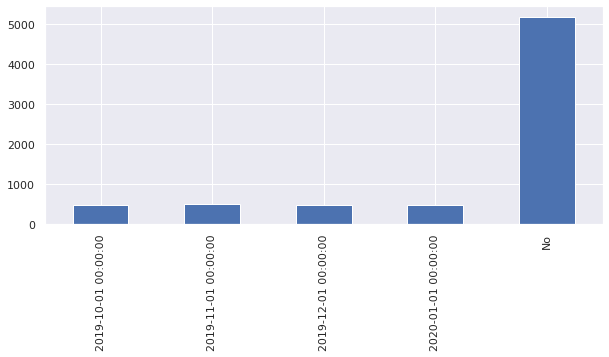

In [26]:
contracts.end_date.value_counts().sort_index().plot(kind='bar');

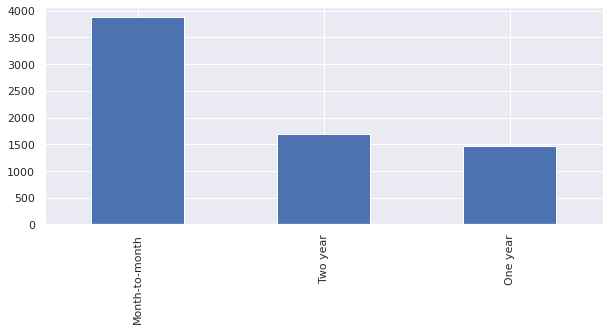

In [27]:
contracts.type.value_counts().plot(kind='bar');

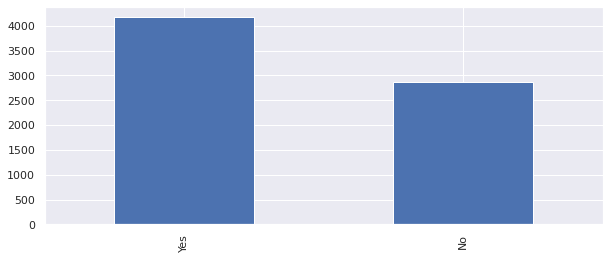

In [28]:
contracts.paperless_billing.value_counts().plot(kind='bar');

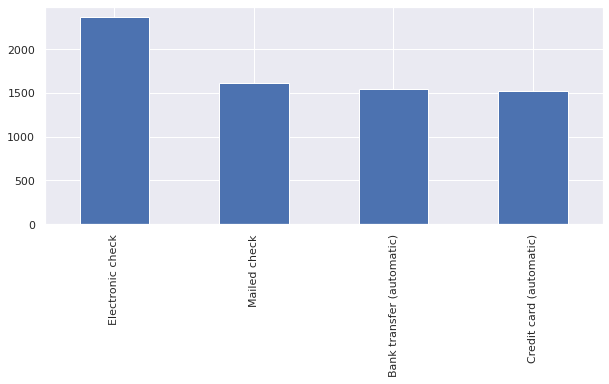

In [29]:
contracts.payment_method.value_counts().plot(kind='bar');

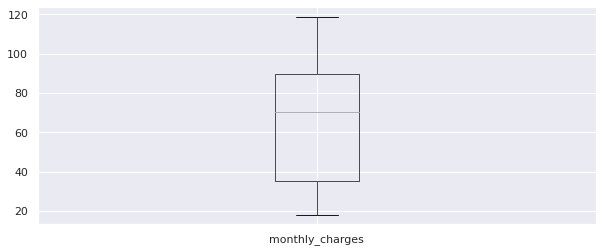

In [30]:
contracts.boxplot(column=['monthly_charges']);

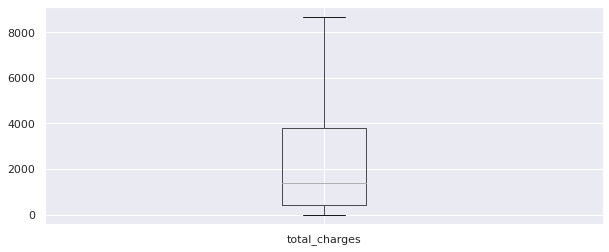

In [31]:
 contracts.boxplot(column=['total_charges']);

#### Conclusion

We could see that the departure of clients is fixed for the last 4 months. Among the calculation options, the most popular monthly. Most prefer paperless payment. Electronic checks are preferred by most users. The maximum monthly payment is 118. The bulk of all costs lie in the range from 400 to 3700.

### Personal data

In [32]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [33]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [34]:
personal.duplicated().sum()

0

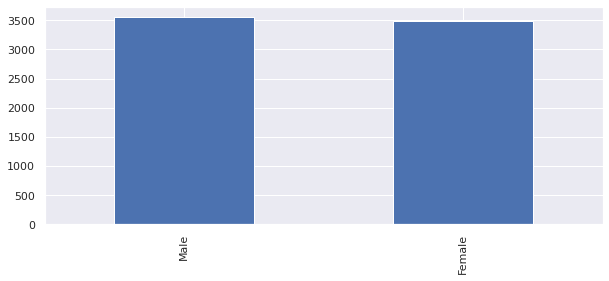

In [35]:
personal.gender.value_counts().plot(kind='bar');

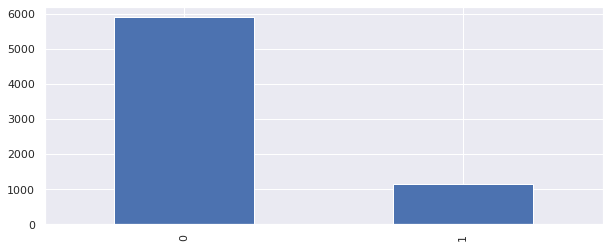

In [36]:
personal.senior_citizen.value_counts().plot(kind='bar');

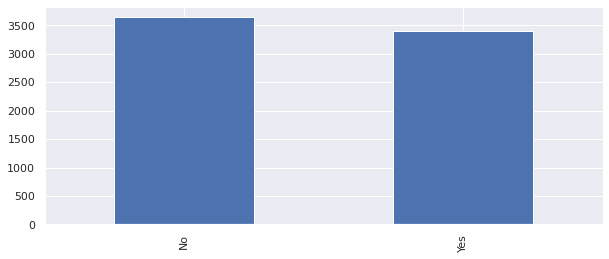

In [37]:
personal.partner.value_counts().plot(kind='bar');

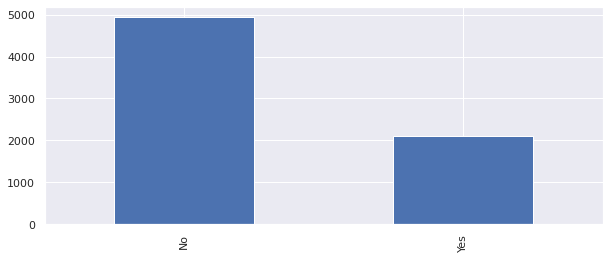

In [38]:
personal.dependents.value_counts().plot(kind='bar');

#### Conclusion

The number of male and female users is approximately the same. We have 14% of pensioners. Approximately equal number of people married, most do not have dependents.

### Internat services info

In [39]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [40]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [41]:
internet.duplicated().sum()

0

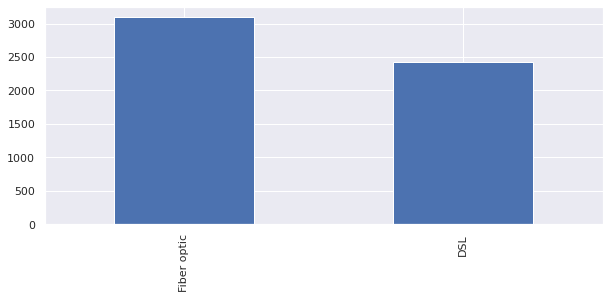

In [42]:
internet.internet_service.value_counts().plot(kind='bar');

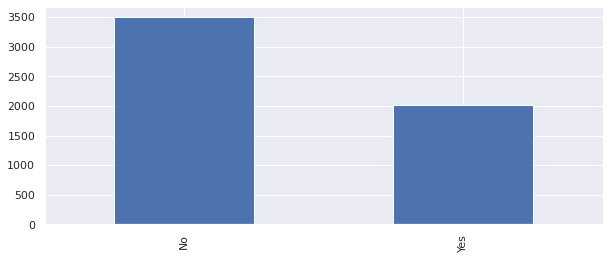

In [43]:
internet.online_security.value_counts().plot(kind='bar');

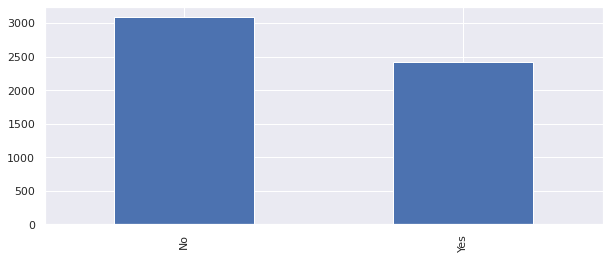

In [44]:
internet.online_backup.value_counts().plot(kind='bar');

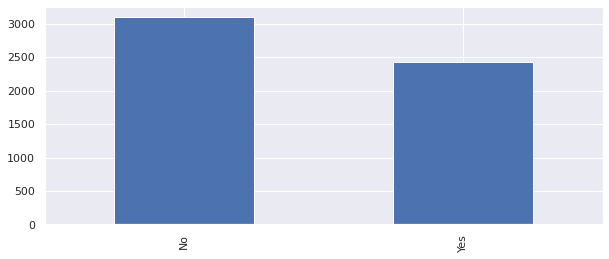

In [45]:
internet.device_protection.value_counts().plot(kind='bar');

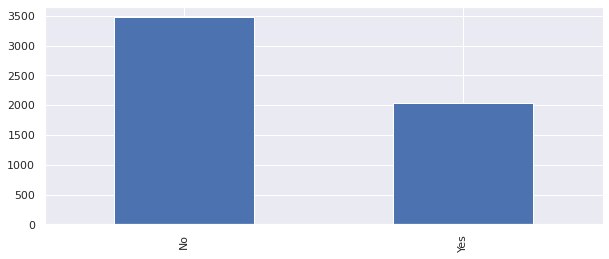

In [46]:
internet.tech_support.value_counts().plot(kind='bar');

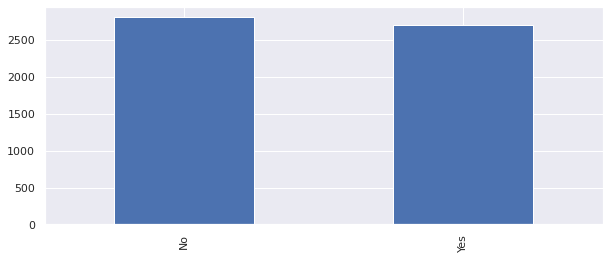

In [47]:
internet.streaming_t_v.value_counts().plot(kind='bar');

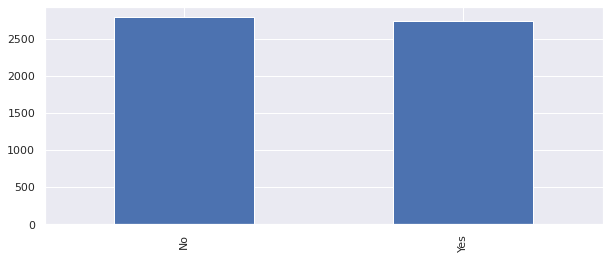

In [48]:
internet.streaming_movies.value_counts().plot(kind='bar');

#### Conclusion

Internet services are used by 5517 people. The number of Fiber Optic and DSL users differs slightly in favor of Fiber Optic. The use of Internet services is approximately equally divided between those who use them and those who do not use them. Those who do not use always more.

### Telephony information

In [49]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [50]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [51]:
phone.duplicated().sum()

0

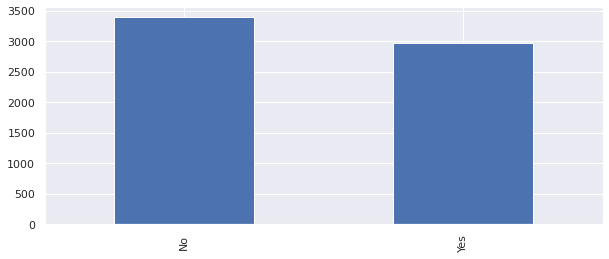

In [52]:
phone.multiple_lines.value_counts().plot(kind='bar');

#### Conclusion

The number of telephony users is 6361, the use of multiple_lines is about half.

### Merging tables

In [53]:
df = (contracts.merge(personal, how='left', on='customer_id')
      .merge(internet, how='left', on='customer_id')
      .merge(phone, how='left', on='customer_id'))

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [55]:
df[df.isnull().any(axis=1)].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [56]:
df = df.fillna('NotInUse')

In [57]:
df[df.isnull().any(axis=1)].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines


In [58]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NotInUse
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NotInUse
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Correlation

In [59]:
corr_columns = ['end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines']

In [60]:
corr = df[corr_columns].phik_matrix(['monthly_charges', 'total_charges'])

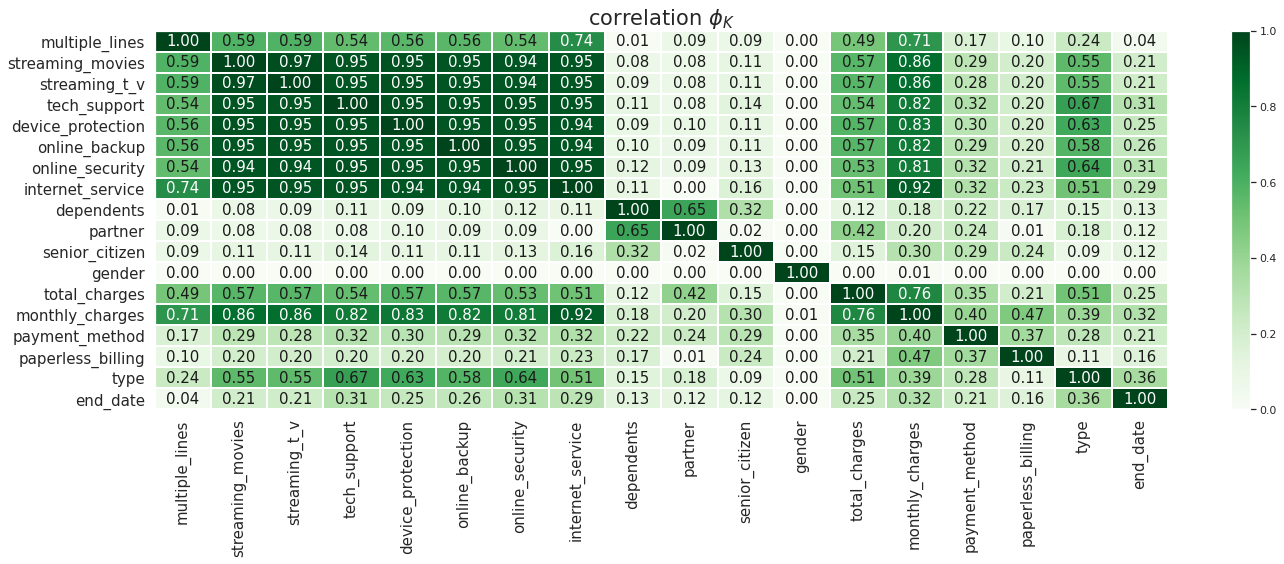

In [61]:
plot_correlation_matrix(corr.values, 
                        x_labels=corr.columns, 
                        y_labels=corr.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

### Conclusion

The data looks correct. Changed column types and names. Investigated cat. and numeric features in each dataset. The tables were merged, the empty values after the merger were filled with the value 'NotInUse'. We see that the departure of clients is fixed for the last 4 months. There are some correlations between the data, while they do not tell us anything.

## Preparation for training

### Adding features

Let's add a target feature based on the end_date field.

In [62]:
df['target'] = df.end_date.apply(lambda date: 0 if date == 'No' else 1 )

In [63]:
df.loc[df[df.end_date == 'No'].index, 'end_date'] = "02.01.2020"

In [64]:
df.end_date = pd.to_datetime(df.end_date)

Let's add a sign of the number of days of using the provider's services.

In [65]:
df['days_in_use'] = (df.end_date - df.begin_date).dt.days

In [66]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target,days_in_use
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,NotInUse,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NotInUse,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,61


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

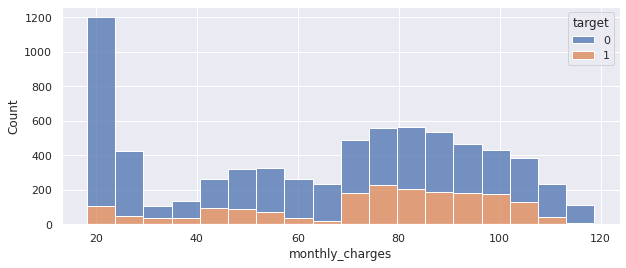

In [68]:
sns.histplot(data=df, x="monthly_charges", hue="target", multiple="stack");

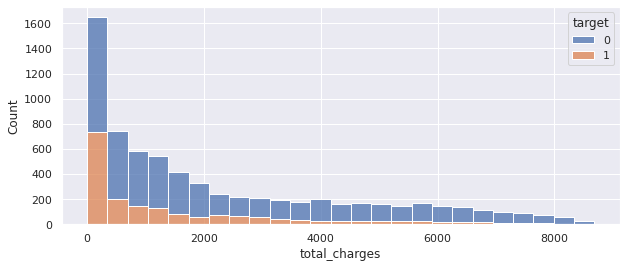

In [69]:
sns.histplot(data=df, x="total_charges", hue="target", multiple="stack");

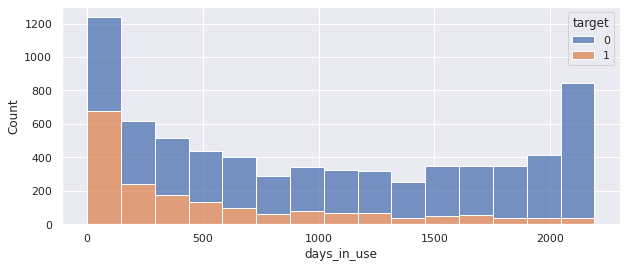

In [70]:
sns.histplot(data=df, x="days_in_use", hue="target", multiple="stack");

In [71]:
df[df.target == 1].shape[0] / df.shape[0]

0.2653698707936959

We have 26% target data. This will be enough for learning.

### Replacement cat. types

In [72]:
cat_features = ['type', 'paperless_billing', 'payment_method',
                'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
               'online_backup','device_protection','tech_support','streaming_t_v','streaming_movies',
               'multiple_lines']
df[cat_features] = df[cat_features].astype('category')

### Data partitioning

From the features, we will remove the target feature, the client id, since it is unique, the beginning and end of the contract, since the use of the Internet most likely does not bear signs of seasonality, and we have only observed the outflow for the last 4 months. The number of users of different genders of their outflow is approximately equal, we will also remove it.

In [73]:
features_to_delete = ['target', 'customer_id', 'begin_date', 'end_date', 'gender']

In [74]:
features = df.drop(features_to_delete, axis=1)
target = df.target

In [75]:
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify=df['target'], test_size=0.25, random_state=rnd_state)

### Scaling 

In [76]:
numeric = ['monthly_charges', 'total_charges', 'days_in_use']
scaler = StandardScaler()
scaler.fit(X_train[numeric])

StandardScaler()

In [77]:
pd.options.mode.chained_assignment = None
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Encoding

In [78]:
X_train_ohe = pd.get_dummies(X_train, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, drop_first=True)

In [79]:
(X_train_ohe.columns == X_test_ohe.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Fit models

In [80]:
#find best model with GridSearchCV
def get_best_by_grid_search(estimator, parameters, f_train, t_train, cat_features = None):
    gs = GridSearchCV(estimator, parameters, scoring='roc_auc', n_jobs=-1)
    if (cat_features != None):
        gs.fit(f_train, t_train, cat_features=cat_features)
    else:
        gs.fit(f_train, t_train)        
    
    for p in parameters:
        print('Best parameters:', p, gs.best_estimator_.get_params()[p])
    print('Best roc_auc:', gs.best_score_)
    return gs.best_estimator_

### CatBoost

In [81]:
parameters_cb = ({'learning_rate': [0.1, 0.01],
        'depth': [10]
        })

In [82]:
%%time
best_cb = get_best_by_grid_search(CatBoostClassifier(eval_metric='AUC', random_seed=rnd_state, 
                                                     verbose=False, iterations=500), 
                                  parameters_cb, X_train, y_train, cat_features=cat_features)

Best parameters: learning_rate 0.1
Best parameters: depth 10
Best roc_auc: 0.8763262435206685
CPU times: user 4min 25s, sys: 2.79 s, total: 4min 27s
Wall time: 4min 36s


### Random forest

In [83]:
parameters_rf = ({'max_depth':range(5,11), 
                  'n_estimators':range(20,25)
                 })

In [84]:
%%time
best_rf = get_best_by_grid_search(RandomForestClassifier(random_state=rnd_state), parameters_rf, X_train_ohe, y_train)

Best parameters: max_depth 8
Best parameters: n_estimators 20
Best roc_auc: 0.8579347801875272
CPU times: user 12.6 s, sys: 95.4 ms, total: 12.7 s
Wall time: 12.9 s


### Log. regression

In [85]:
parameters_lr = {'C': [0.001,0.01,0.1,1,10,100,1000], 'penalty':['l1','l2']}

In [86]:
%%time
best_lr = get_best_by_grid_search(LogisticRegression(random_state=rnd_state, max_iter=100,
                                                     solver = 'liblinear'), 
                                                     parameters_lr, X_train_ohe, y_train)

Best parameters: C 1000
Best parameters: penalty l2
Best roc_auc: 0.8482857909370594
CPU times: user 9.96 s, sys: 6.83 s, total: 16.8 s
Wall time: 16.8 s


### Conclusion


The best result roc_auc: 0.88 was shown by the CatBoost model. We will choose it for testing.

## Test best model

In [87]:
probabilities_test = best_cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(y_test, probabilities_one_test)
print('ROC-AUC:',roc_auc)

ROC-AUC: 0.8782173695759378


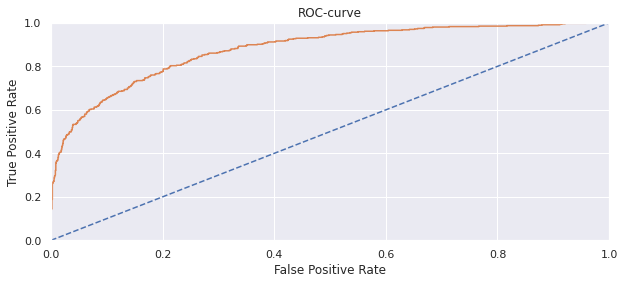

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [89]:
cat_boost_pred = best_cb.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, cat_boost_pred))

accuracy_score: 0.8432708688245315


In [90]:
pool = Pool(X_test, y_test, cat_features=cat_features)

In [91]:
data = pd.DataFrame({'feature_importance': best_cb.get_feature_importance(pool), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

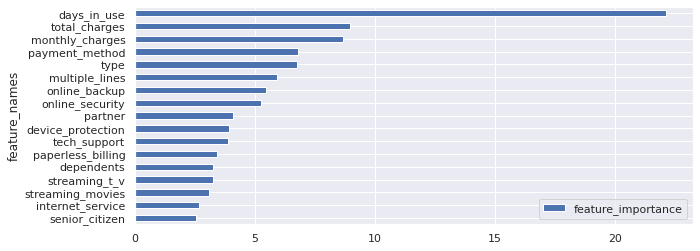

In [92]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance');

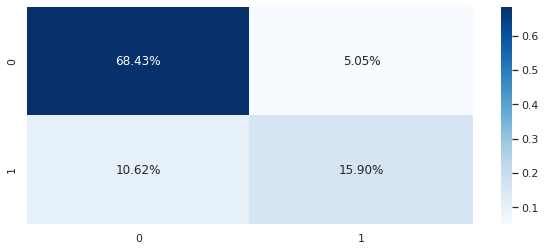

In [93]:
conf_mat = confusion_matrix(y_test, cat_boost_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues');

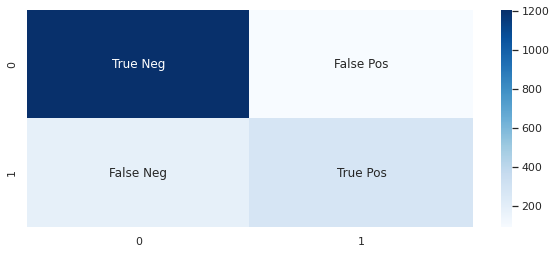

In [94]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues');

### Conclusion

The best model showed ROC-AUC: 0.88, accuracy: 0.84. The greatest contribution is made by signs of the number of days of use and spending by users. Businesses should pay attention to users who have recently used the services of a provider and have not spent a significant amount. At 5% we may mistakenly give discounts, at 10% we may not predict the customer's exit.